In [1]:
!pip install pm4py

     ---------------------------------------- 1.8/1.8 MB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 278.7/278.7 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     --------------------------------------- 12.7/12.7 MB 24.2 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=9b9fa071802ea7357dae77330f4a3fbc8d874d95b7c9d90a3351adf9af09fc40
  Stored in directory: c:\users\jinyoung\appdata\local\pip\cache\wheels\fe\cd\78\a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
  Created wheel for pyvis: filename=pyvis-0.2.1-py3-none-any.whl size=23667 sha256=3daf85a8c8f8c0e7

## 참고 : [링크](https://process-mining.tistory.com/140)

In [4]:
import statistics 
import pm4py 
import matplotlib.pyplot as plt 

from pm4py.objects.log.importer.xes import importer
from pm4py.objects.conversion.log.converter import to_data_frame
from pm4py.algo.filtering.pandas.attributes import attributes_filter
from pm4py.statistics.traces.log import case_statistics
from pm4py.objects.log.util import interval_lifecycle
from pm4py.statistics.traces.log import case_arrival
from pm4py.statistics.sojourn_time.log import get as soj_time_get 
from pm4py.visualization.graphs import visualizer as graphs_visualizer 
from pm4py.util import constants
from pm4py.algo.filtering.log.timestamp import timestamp_filter 
from pm4py.algo.filtering.log.end_activities import end_activities_filter
from pm4py.algo.filtering.log.start_activities import start_activities_filter 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner 
from pm4py.algo.discovery.inductive import algorithm as inductive_miner 
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery 
from pm4py.visualization.dfg import visualizer as dfg_visualization 
from pm4py.visualization.petri_net import visualizer as pn_visualizer 
from pm4py.visualization.decisiontree import visualizer as tree_visualizer 
from pm4py.algo.decision_mining import algorithm as decision_mining

In [5]:
# Data Import 
log = importer.apply("repairExample.xes")

parsing log, completed traces :: 100%|██████████| 1104/1104 [00:00<00:00, 2193.22it/s]


In [6]:
# 데이터 확인 로그 print
print(log[0])

{'attributes': {'concept:name': '1', 'description': 'Simulated process instance'}, 'events': [{'org:resource': 'System', 'time:timestamp': datetime.datetime(1970, 1, 2, 12, 23, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'concept:name': 'Register', 'lifecycle:transition': 'complete'}, '..', {'numberRepairs': '0', 'org:resource': 'System', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(1970, 1, 2, 13, 10, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'concept:name': 'Archive Repair', 'defectFixed': 'true'}]}


In [7]:
print(log[0][0])

{'org:resource': 'System', 'time:timestamp': datetime.datetime(1970, 1, 2, 12, 23, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'concept:name': 'Register', 'lifecycle:transition': 'complete'}


In [8]:
df = to_data_frame.apply(log)
df.head()

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name,case:description,defectType,phoneType,numberRepairs,defectFixed
0,System,1970-01-02 12:23:00+01:00,Register,complete,1,Simulated process instance,NaN,NaN,NaN,NaN
1,Tester3,1970-01-02 12:23:00+01:00,Analyze Defect,start,1,Simulated process instance,NaN,NaN,NaN,NaN
2,Tester3,1970-01-02 12:30:00+01:00,Analyze Defect,complete,1,Simulated process instance,6,T2,NaN,NaN
3,SolverC1,1970-01-02 12:31:00+01:00,Repair (Complex),start,1,Simulated process instance,NaN,NaN,NaN,NaN
4,SolverC1,1970-01-02 12:49:00+01:00,Repair (Complex),complete,1,Simulated process instance,NaN,NaN,NaN,NaN


## EDA


### Activity & Resource Analysis

In [9]:
# activity 목록 도출
activities = attributes_filter.get_attribute_values(df, attribute_key="concept:name")
# Resource 목록 도출
resources = attributes_filter.get_attribute_values(df, attribute_key="org:resource")

In [10]:
print(activities)

{'Test Repair': 3016, 'Analyze Defect': 2208, 'Repair (Simple)': 1570, 'Repair (Complex)': 1449, 'Register': 1104, 'Inform User': 1102, 'Archive Repair': 1000, 'Restart Repair': 406}


Text(0.5, 1.0, 'Resource Distribution')

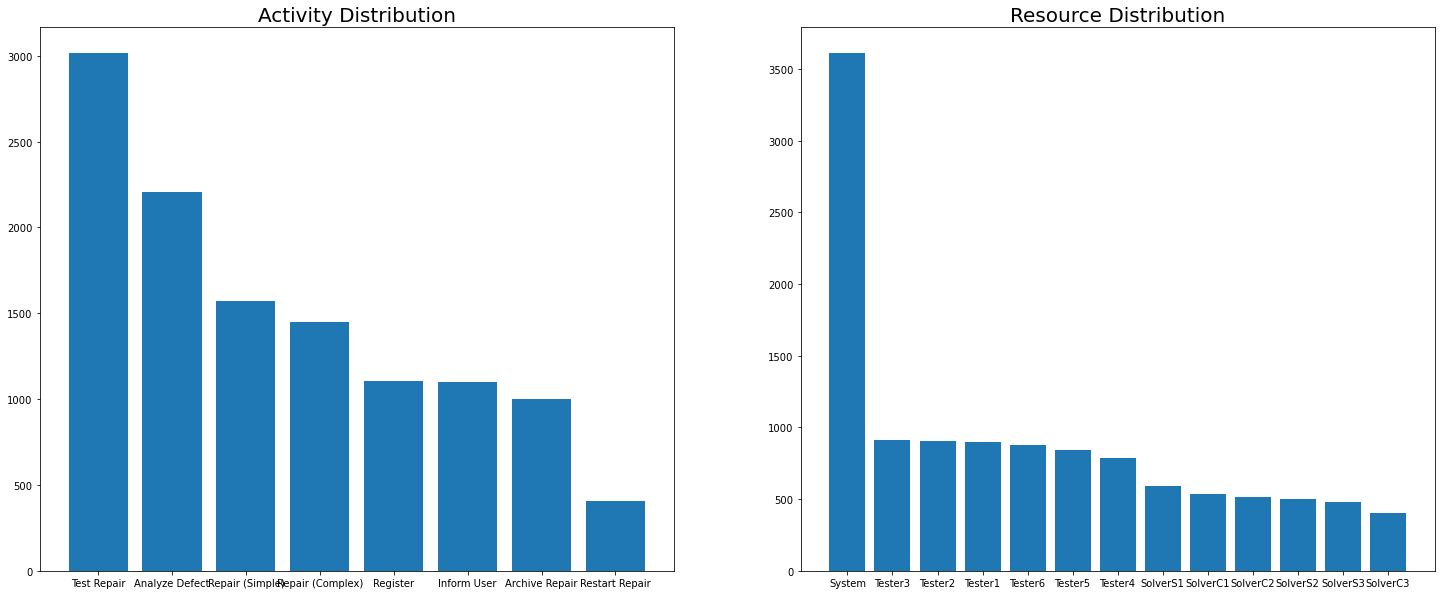

In [11]:
# activity와 resource를 Bar Chart로 표현해보기
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
ax = ax.ravel()
ax[0].bar(x=list(activities.keys()), height=list(activities.values()))
ax[0].set_title("Activity Distribution", fontsize=20)
ax[1].bar(x=list(resources.keys()), height=list(resources.values()))
ax[1].set_title("Resource Distribution", fontsize=20)


### Start & End Activities

In [12]:
# Start activity와 end activity의 목록 도출
start_activities = start_activities_filter.get_start_activities(log)
end_activities = end_activities_filter.get_end_activities(log)

Text(0.5, 1.0, 'End Activities Distribution')

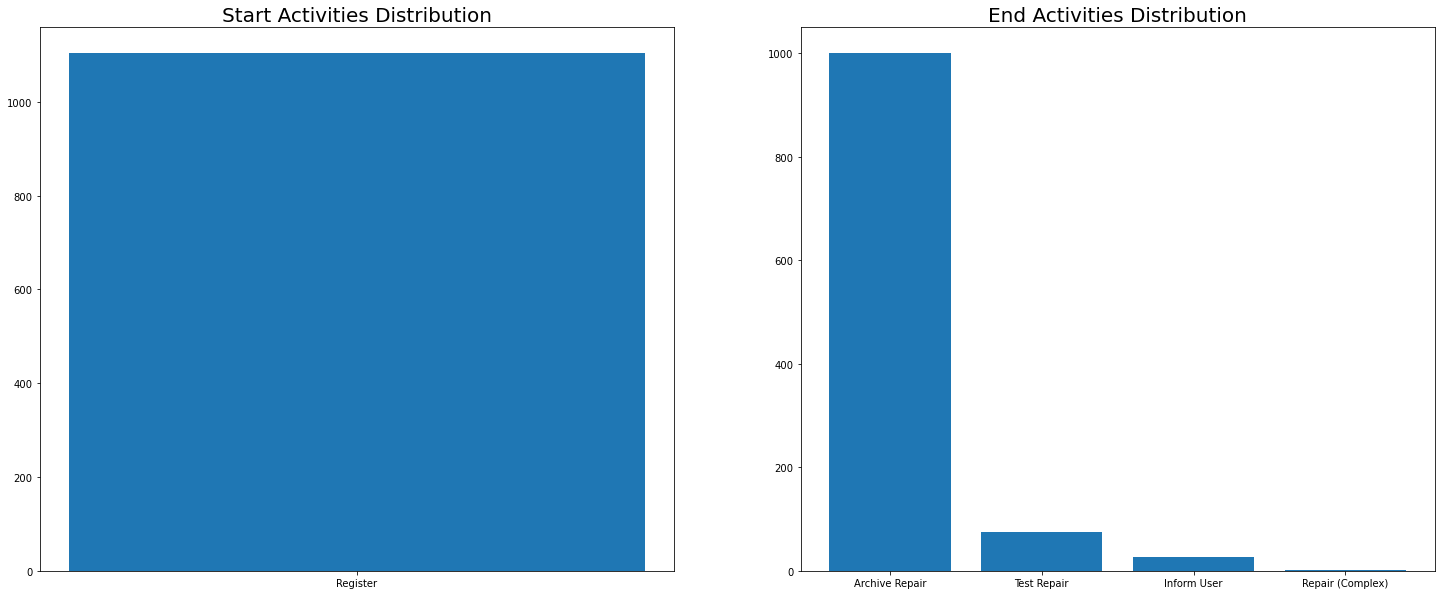

In [14]:
# Bar chart 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
ax = ax.ravel()
ax[0].bar(x=list(start_activities.keys()), height=list(start_activities.values()))
ax[0].set_title("Start Activities Distribution", fontsize=20)
ax[1].bar(x=list(end_activities.keys()), height=list(end_activities.values()))
ax[1].set_title("End Activities Distribution", fontsize=20)

### Filtering

In [16]:
# 기존 이벤트 로그의 종료 액티비티 목록
print(end_activities)

# filtering
filtered_log = end_activities_filter.apply(log, ["Repair (Complex)"], parameters={'positive' : False})
filtered_end_activities = end_activities_filter.get_end_activities(filtered_log)

# Filtering된 이벤트 로그의 종료 액티비티 목록
print(filtered_end_activities)

{'Archive Repair': 1000, 'Test Repair': 75, 'Inform User': 27, 'Repair (Complex)': 2}
{'Archive Repair': 1000, 'Test Repair': 75, 'Inform User': 27}


### Process Discovery

In [18]:
# Process discovery
net_in, im_in, fm_in = inductive_miner(filtered_log)

# Process Model Visualization 
gviz_in = pn_visualizer.apply(net_in, im_in, fm_in)
pn_visualizer.apply(gviz_in)

TypeError: 'module' object is not callable